# Build high-graded training data

`boreal training data`
### A full domain yearly/combined sample of high graded covar-extracted filtered ATL08 v6 observations
Used to develop a 'boreal-wide' model used in tandem with regional (aka tile-specific) models for estimating height or AGB.

`tile training data`
### A tile-specific combined sample of high-graded covar-extracted filtered ATL08 v6 observations
Used to develop 'tile-specific' models used in tandem with boreal-wide model for estimating height or AGB.


In [1]:
import geopandas as gpd
import pandas as pd
import s3fs
import sys, os
import numpy as np

ICESAT2_BOREAL_REPO_PATH = '/projects/code/icesat2_boreal'               #'/projects/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'
sys.path.append(ICESAT2_BOREAL_LIB_PATH)

In [2]:
import importlib
import mosaiclib
importlib.reload(mosaiclib)
from mosaiclib import *

In [3]:
ATL08_FILT_TINDEX_FN_DICT

{'c2020spring2022': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt/c2020/tile_atl08/ATL08_filt_tindex_master.csv',
 'c2020fall2022v1': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_gedi_rh/ATL08_filt_tindex_master.csv',
 'c2020fall2022v2': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv',
 'c2020_v005': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/tile_atl08/c2020_v005/ATL08_filt_tindex_master.csv',
 '2019': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2019/ATL08_filt_tindex_master.csv',
 '2020': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2020/ATL08_filt_tindex_master.csv',
 '2021': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2021/ATL08_filt_tindex_master.csv',
 '2022': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract

#### Column organization, if needed

In [4]:
# from SlideRule with ATL08
ATL08_COLS_LIST =    ['ph_count', 'solar_elevation', 'snowcover', 'gnd_ph_count', 'veg_ph_count','segment_landcover', 'segment_snowcover','segment_cover', 'h_te_uncertainty','h_canopy_uncertainty']
ATL08_COLS_LIST +=   ['h_canopy','rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80', 'rh85', 'rh90', 'rh95']
# From Topo
TOPO_COLS_LIST =     ['elevation', 'slope', 'tsri', 'tpi', 'slopemask'] 
# From HLS greenest pixel comps
MS_COLS_LIST =       ['Blue', 'Green', 'Red', 'NIR', 'SWIR', 'SWIR2', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2', 'TCB', 'TCG', 'TCW', 'ValidMask', 'Xgeo', 'Ygeo', 'JulianDate', 'yearDate']
# From S1 triseasonal comps
SAR_COLS_LIST =      ['vv_median_frozen', 'vh_median_frozen', 'vv_median_summer', 'vh_median_summer', 'vv_median_shoulder', 'vh_median_shoulder', 'n_frozen', 'n_summer', 'n_shoulder']
# From our conversion from datetime
DATETIME_COLS_LIST = ['y', 'm', 'd', 'doy']
# Needed to get lat lon
GEO_COLS_LIST =      ['geometry']

COLS_LIST = ATL08_COLS_LIST + TOPO_COLS_LIST + MS_COLS_LIST + SAR_COLS_LIST + DATETIME_COLS_LIST + GEO_COLS_LIST
print(COLS_LIST)
len(COLS_LIST)

['ph_count', 'solar_elevation', 'snowcover', 'gnd_ph_count', 'veg_ph_count', 'segment_landcover', 'segment_snowcover', 'segment_cover', 'h_te_uncertainty', 'h_canopy_uncertainty', 'h_canopy', 'rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80', 'rh85', 'rh90', 'rh95', 'elevation', 'slope', 'tsri', 'tpi', 'slopemask', 'Blue', 'Green', 'Red', 'NIR', 'SWIR', 'SWIR2', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2', 'TCB', 'TCG', 'TCW', 'ValidMask', 'Xgeo', 'Ygeo', 'JulianDate', 'yearDate', 'vv_median_frozen', 'vh_median_frozen', 'vv_median_summer', 'vh_median_summer', 'vv_median_shoulder', 'vh_median_shoulder', 'n_frozen', 'n_summer', 'n_shoulder', 'y', 'm', 'd', 'doy', 'geometry']


60

In [5]:
def sample_parquet(fn, N_SAMPLES=3, DROP_COL_LIST=['binsize','num_bins'], SUBSET_COLS_LIST=None, MS_COLS_LIST=MS_COLS_LIST, N_DAYS=None, DIFF_MEAN_MAX_CAN=25):
    
    if isinstance(fn, pd.DataFrame):
        gdf = fn
    else:
        gdf = gpd.read_parquet(fn)
    
    # High-grade based on delta 
    if N_DAYS is not None:
        gdf = highgrade_sample(gdf, cols_list = MS_COLS_LIST, n_days=N_DAYS, diff_mean_max_can=DIFF_MEAN_MAX_CAN)
        
    # Drop some columns
    if DROP_COL_LIST is not None:
        for col in DROP_COL_LIST:
            if col in gdf.columns.to_list():
                gdf.drop(col, axis=1, inplace=True)
                
    # Subset columns            
    if SUBSET_COLS_LIST is not None:            
        gdf = gdf[SUBSET_COLS_LIST]
            
    gdf['lat'] = gdf.to_crs(4326).geometry.y
    gdf['lon'] = gdf.to_crs(4326).geometry.x
    
    if gdf.shape[0] > N_SAMPLES:
        return gdf.sample(n=N_SAMPLES)
    else:
        return gdf
    
def highgrade_sample(gdf, cols_list = MS_COLS_LIST, n_days=0, diff_mean_max_can=25, LIDAR_BEFORE=True):
    '''
    Highgrade an ATL08 extracted covars gdf by subsetting to obs with LTE n_days difference between ATL08 and HLS 
    '''
    # Find and remove ATL08 that dont have HLS
    gdf[MS_COLS_LIST] = gdf[MS_COLS_LIST].replace([-9999], [np.nan])
    gdf.dropna(inplace=True)
    
    # Calculate difference: ATL08 doy - HLS JulianDate
    gdf['doy_dif'] = gdf['doy'] - gdf['JulianDate'] 
    
    if LIDAR_BEFORE:
        # Subset based on n_days diff (lidar before HLS); days diff will thus be negative
        gdf = gdf[((gdf.doy_dif >= n_days) & 
                   (gdf.doy_dif <= 0))
                 ]
    else:
        # Subset based on n_days diff (lidar before or after HLS)
        gdf = gdf[abs(gdf.doy_dif) <= n_days]
    
    # Rough high grade based on diff of ATL08 heights to get rid of obvious blunders
    gdf = gdf[abs(gdf.h_max_canopy - gdf.h_mean_canopy) <= diff_mean_max_can]
    
    return gdf    

In [6]:
from multiprocessing import Pool
from functools import partial

In [7]:
OUTDIR = '/projects/my-public-bucket/DPS_tile_lists/BOREAL_ATL08_TRAIN'
!mkdir -p $OUTDIR

## Build a high-graded `boreal train data` sample
Use only sample that have a small diff between ATL08 and HLS greenest pixel

### Sampling parameters

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
DELTA_DAYS = 0 
N_SAMPLES_PER_TILE = 10
DIFF_MEAN_MAX_CAN = 25
BUILD_ACROSS_YEARS = True

### Loop over years and multiprocess the `boreal_train_data`

In [90]:
DICT_YEAR_BOREAL_SAMPLE_GDF = dict()
gdf_list = []

for YEAR in list(range(2019,2023+1)):
    
    tindex_df = pd.read_csv(f'/projects/shared-buckets/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/{YEAR}/ATL08_filt_tindex_master.csv')

    with Pool(processes=30) as pool:
        sampled_gdf_list = pool.map(partial(sample_parquet, N_SAMPLES=N_SAMPLES_PER_TILE, N_DAYS=DELTA_DAYS), 
                            tindex_df.s3_path.to_list()
                                 )
    yearly_sample_gdf = pd.concat(sampled_gdf_list)
    
    print(f"{YEAR}: n cols = {len(yearly_sample_gdf.columns)}")
    
    if BUILD_ACROSS_YEARS:
        DICT_YEAR_BOREAL_SAMPLE_GDF[YEAR] = yearly_sample_gdf
        gdf_list.append(yearly_sample_gdf)
    else:
        yearly_sample_gdf.to_csv(os.path.join(OUTDIR, f'boreal_train_data_{YEAR}_n{N_SAMPLES_PER_TILE}_diffday{DELTA_DAYS}.csv'), index=False)

full_sample_gdf = pd.concat(gdf_list)
full_sample_gdf.to_csv(os.path.join(OUTDIR, f'boreal_train_data_2019-2023_n{N_SAMPLES_PER_TILE}_diffday{N_DAYS_ATL08_HLS_DIF}.csv'), index=False)

2019: n cols = 80
2020: n cols = 80
2021: n cols = 71
2022: n cols = 71
2023: n cols = 71


In [91]:
full_sample_gdf.shape

(72910, 80)

In [ ]:
full_sample_gdf.sample(frac=0.5).explore(column='h_canopy', cmap='magma', vmax=20,tiles='https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr=' ')

## Build a high-graded `tile train data`: tile-specific `geoparquets` from across all years
Use only sample that have a small diff between ATL08 and HLS greenest pixel

In [10]:
ATL08_FILT_TINDEX_FN_DICT

{'c2020spring2022': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt/c2020/tile_atl08/ATL08_filt_tindex_master.csv',
 'c2020fall2022v1': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_gedi_rh/ATL08_filt_tindex_master.csv',
 'c2020fall2022v2': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv',
 'c2020_v005': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/tile_atl08/c2020_v005/ATL08_filt_tindex_master.csv',
 '2019': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2019/ATL08_filt_tindex_master.csv',
 '2020': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2020/ATL08_filt_tindex_master.csv',
 '2021': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2021/ATL08_filt_tindex_master.csv',
 '2022': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract

In [19]:
DELTA_DAYS = -7          # num days between ATL08 and HLS obs
N_SAMPLES_PER_TILE = 1e6 # choosing a large sample size means all obs left after high-grade will be returned
DIFF_MEAN_MAX_CAN = 25   # max diff between mean and max canopy height; helps eliminate noisy data resulting in erroneously tall heights
YEAR_MIN = 2019
YEAR_MAX = 2023

### Loop over years and multiprocess the `tile_train_data`

In [12]:
OUTDIR_TILE_TRAIN = f'/projects/my-private-bucket/data/build_tile_atl08_training/delta_days_{DELTA_DAYS:03}'
if DELTA_DAYS < 0: 
    OUTDIR_TILE_TRAIN = f'/projects/my-private-bucket/data/build_tile_atl08_training/delta_days_n{abs(DELTA_DAYS):03}'
!mkdir -p $OUTDIR_TILE_TRAIN

In [13]:
# Get any tindex to supply a tile list
tindex_df = pd.read_csv(ATL08_FILT_TINDEX_FN_DICT['2020'])

In [20]:
def local_to_s3(url, user = 'montesano', type='public'):
    ''' A Function to convert local paths to s3 urls'''
    if '/my-' in url:
        if type == 'public':
            replacement_str = f's3://maap-ops-workspace/shared/{user}'
        else:
            replacement_str = f's3://maap-ops-workspace/{user}'
        return url.replace(f'/projects/my-{type}-bucket', replacement_str)
    if '/shared-buckets/' in url:
        replacement_str = f's3://maap-ops-workspace/shared'
        return url.replace(f'/projects/shared-buckets', replacement_str)
    
def build_tile_atl08_training(TILE_NUM, ATL08_FILT_TINDEX_FN_DICT=ATL08_FILT_TINDEX_FN_DICT, YEAR_MIN=2019, YEAR_MAX=2023, OUTDIR=OUTDIR_TILE_TRAIN, RETURN_DF=False):
    
    '''Build tile-specific ATL08 training across all years
    '''
    
    TILE_GDF_FN_LIST = []
    
    # Get all geoparquets for this tile 
    for YEAR in list(range(YEAR_MIN, YEAR_MAX+1)):
        tmp = pd.read_csv(ATL08_FILT_TINDEX_FN_DICT[f'{YEAR}'])
        # Select the s3 path to the geoparquet for the tile from this year
        TILE_GDF_FN_LIST.append(tmp[tmp.tile_num == TILE_NUM].s3_path.to_list()[0])
    
    # Use first fn as guide for naming output combined file
    out_fn = os.path.join(OUTDIR, f'atl08_006_030m_{YEAR_MIN}_{YEAR_MAX}_06_09_filt_covars_{TILE_NUM:06}.parquet')    
    
    # High-grade the ATL08 from all years for this tile
    tile_gdf = pd.concat([sample_parquet(fn, N_SAMPLES=N_SAMPLES_PER_TILE, N_DAYS=DELTA_DAYS) for fn in TILE_GDF_FN_LIST])
    tile_gdf.to_parquet(out_fn)
    
    n_obs = tile_gdf.shape[0]
    
    if RETURN_DF:
        return tile_gdf
    else:
        return out_fn, n_obs

In [ ]:
z = build_tile_atl08_training(1711, RETURN_DF=True)
print(z.shape)
z.sample(frac=0.5).explore(column='y', cmap='nipy_spectral', vmax=2023, vmin=2019,tiles='https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr=' ', legend=True)

# Create high-graded ATL08 parquets combining data from all years and write tindex

In [24]:
outdir_tindex = f'/projects/my-public-bucket/DPS_tile_lists/build_tile_atl08_training/{YEAR_MIN}_{YEAR_MAX}'
!mkdir -p $outdir_tindex

In [49]:
outdir_tindex

'/projects/my-public-bucket/DPS_tile_lists/build_tile_atl08_training/2019_2023'

In [ ]:
tindex = pd.DataFrame(columns=['s3_path', 'local_path', 'file','tile_num','n_obs'])

for TILE_NUM in tindex_df.tile_num.to_list():
    
    out_fn, n_obs = build_tile_atl08_training(TILE_NUM, YEAR_MIN=2019, YEAR_MAX=2023, OUTDIR = OUTDIR_TILE_TRAIN)
    s3_path = local_to_s3(out_fn, type='private')
    tindex = pd.concat([pd.DataFrame([[s3_path,out_fn,os.path.basename(out_fn),TILE_NUM,n_obs]], columns=tindex.columns), tindex], ignore_index=True)


In [50]:
tindex.n_obs = tindex.n_obs.astype(int)
tindex.tile_num = tindex.tile_num.astype(int)
tindex.to_csv(f'{outdir_tindex}/ATL08_filt_tindex_master.csv', index=False)
print(f'{outdir_tindex}/ATL08_filt_tindex_master.csv')

/projects/my-public-bucket/DPS_tile_lists/build_tile_atl08_training/2019_2023/ATL08_filt_tindex_master.csv


In [41]:
tindex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   s3_path     4942 non-null   object
 1   local_path  4942 non-null   object
 2   file        4942 non-null   object
 3   tile_num    4942 non-null   int64 
 4   n_obs       4942 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 193.2+ KB


## Map n_obs for high-graded tiles

In [58]:
from pylab import *

cmap = cm.get_cmap('inferno', 5)  #magma inferno plasma  
cmap_hex_list = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    cmap_hex_list.append(matplotlib.colors.rgb2hex(rgba))
cmap_hex_list

['#000004', '#57106e', '#bc3754', '#f98e09', '#fcffa4']

In [106]:
import branca
import branca.colormap as cm

pal_nobs_cmap = cm.LinearColormap(colors=['red']+cmap_hex_list,index=[0,1e1,5e2,7.5e3,8.5e3,1e4], vmin=0,vmax=1e4)
pal_nobs_cmap

In [107]:
# Boreal Tiles 
boreal_tiles_model_ready_fn = '/projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg'
boreal_tiles = gpd.read_file(boreal_tiles_model_ready_fn)

In [108]:
boreal_tiles_ATL08_filt = boreal_tiles[['tile_num','n_obs','geometry']].merge(tindex[['tile_num', 'n_obs']], on='tile_num', suffixes = ['.atl08v005',f'.atl08v006'])

In [109]:
import maplib_folium

In [112]:
z = ['a','b']
if isinstance(z, list):
    for z in z:
        print(z)

a
b


In [110]:
m = boreal_tiles.explore(color='gray',
                                  #tiles=maplib_folium.tiler_basemap_image, 
                                  tiles=maplib_folium.tiler_basemap_gray, 
                                  attr=' ', legend_kwds={'caption': '# filtered ATL08 30m obs.'} )

In [ ]:
boreal_tiles_ATL08_filt.explore(m=m, column=f'n_obs.atl08v006', cmap=pal_nobs_cmap, legend=True)

In [90]:
boreal_tiles_ATL08_filt[boreal_tiles_ATL08_filt['n_obs.atl08v006'] < 40
                       ].shape

(234, 4)

array([[<Axes: title={'center': 'n_obs.atl08v006'}>]], dtype=object)

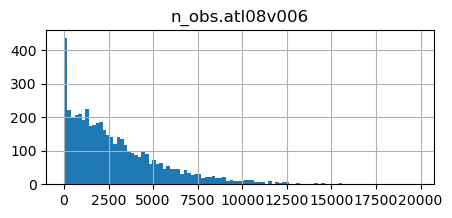

In [93]:
boreal_tiles_ATL08_filt[['n_obs.atl08v006']].hist(bins=100, figsize=(5,2))

In [ ]:
# with Pool(processes=30) as pool:
#     r = pool.map(partial(build_tile_atl08_training), 
#                         tindex_df.tile_num.to_list()
#                              )